<a href="https://colab.research.google.com/github/jiuuu26/ML_website-fingerprint/blob/main/extra_credit/extra_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc, precision_score, recall_score, f1_score, classification_report, average_precision_score
from sklearn.metrics import average_precision_score
import seaborn as sns
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [66]:
mon_features = pd.read_csv('/content/drive/MyDrive/ML_2024_2/extra_mon_23.csv')
mon_label = pd.read_csv('/content/drive/MyDrive/ML_2024_2/extra_mon_label.csv')

In [67]:
features = mon_features
labels = mon_label

In [68]:
labels = labels.squeeze()

In [69]:
labels.shape

(87038,)

In [70]:
if -1 in labels.values:
    print("레이블에 -1이 존재합니다.")
else:
    print("레이블에 -1이 없습니다.")

레이블에 -1이 없습니다.


In [71]:
unique_labels = np.unique(labels)
print(f"현재 고유 레이블 값: {unique_labels}")

현재 고유 레이블 값: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]


In [72]:
print(features.isnull().sum())

num_total_packets                         0
sum_packets                               0
num_incoming_packets                      0
frac_incoming_packets                     0
num_outgoing_packets                      0
frac_outgoing_packets                     0
packet_size_ratios                        0
burst_lengths                             0
average_incoming_ordering              4624
std_dev_incoming_ordering              4624
average_outgoing_ordering             37137
std_dev_outgoing_ordering             37137
avg_packet_size                           0
max_packet_size                           0
avg_inter_arrival_time                    0
var_packet_size                           0
alternative_packets_per_second_sum        0
num_packets_per_second                    0
mean_packets_per_second                   0
std_packets_per_second                    0
med_packets_per_second                    0
first_packet_direction                    0
num_packets_longest_burst       

In [73]:
# 데이터의 절반 이상이 null인 column drop
features = features.drop(['average_outgoing_ordering', 'std_dev_outgoing_ordering'], axis=1)

In [74]:
features = features.fillna(0)

In [75]:
for column in features.columns:
    if features[column].apply(lambda x: isinstance(x, str)).any():
        print(f"Coumn '{column}' contains string data.")
        print("Sample data:", features[column].iloc[0])

In [76]:
print(features.head())
print(features.dtypes)

   num_total_packets  sum_packets  num_incoming_packets  \
0                 51      26112.0                    36   
1                308     157696.0                   308   
2                212     108544.0                   212   
3                517     264704.0                   411   
4                333     170496.0                   333   

   frac_incoming_packets  num_outgoing_packets  frac_outgoing_packets  \
0               0.705882                    15               0.294118   
1               1.000000                     0               0.000000   
2               1.000000                     0               0.000000   
3               0.794971                   106               0.205029   
4               1.000000                     0               0.000000   

   packet_size_ratios  burst_lengths  average_incoming_ordering  \
0            0.416667              2                   17.50000   
1            0.000000              1                  153.50000   
2    

In [77]:
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [78]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (60926,)
y_val shape: (13056,)
y_test shape: (13056,)


In [79]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [80]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [83]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 하이퍼파라미터 설정
input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_train))
learning_rate = 0.001
num_epochs = 150

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size, hidden_size, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/150], Loss: 4.3424, Validation Accuracy: 0.0426
Epoch [2/150], Loss: 4.2325, Validation Accuracy: 0.0508
Epoch [3/150], Loss: 4.1969, Validation Accuracy: 0.0515
Epoch [4/150], Loss: 4.1766, Validation Accuracy: 0.0545
Epoch [5/150], Loss: 4.1594, Validation Accuracy: 0.0578
Epoch [6/150], Loss: 4.1466, Validation Accuracy: 0.0579
Epoch [7/150], Loss: 4.1342, Validation Accuracy: 0.0604
Epoch [8/150], Loss: 4.1248, Validation Accuracy: 0.0646
Epoch [9/150], Loss: 4.1163, Validation Accuracy: 0.0625
Epoch [10/150], Loss: 4.1082, Validation Accuracy: 0.0633
Epoch [11/150], Loss: 4.1000, Validation Accuracy: 0.0672
Epoch [12/150], Loss: 4.0934, Validation Accuracy: 0.0652
Epoch [13/150], Loss: 4.0859, Validation Accuracy: 0.0661
Epoch [14/150], Loss: 4.0800, Validation Accuracy: 0.0706
Epoch [15/150], Loss: 4.0739, Validation Accuracy: 0.0663
Epoch [16/150], Loss: 4.0686, Validation Accuracy: 0.0691
Epoch [17/150], Loss: 4.0627, Validation Accuracy: 0.0671
Epoch [18/150], Loss: 4

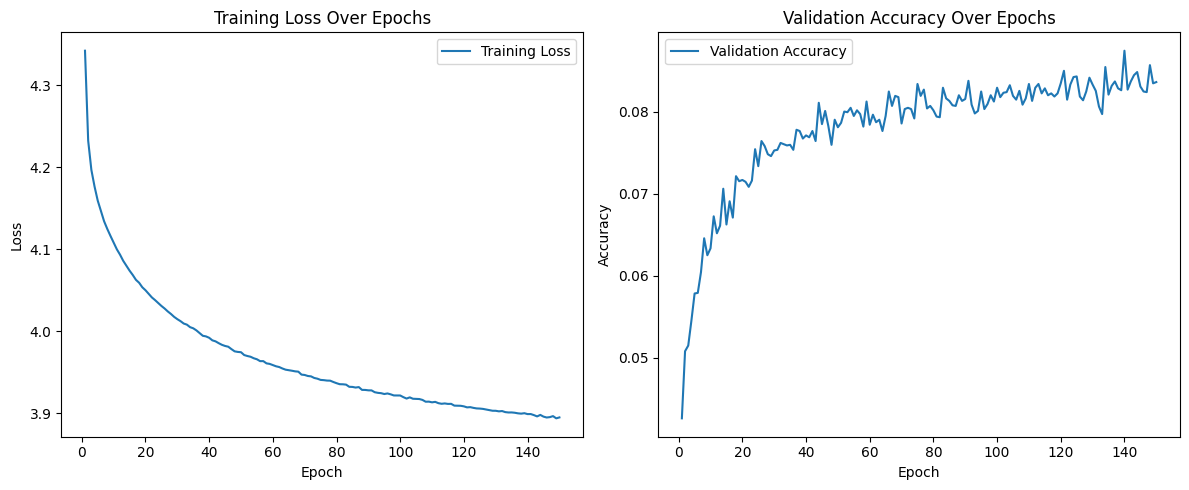

In [84]:
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_val_pred.extend(preds.cpu().numpy())
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# 훈련 과정 시각화
plt.figure(figsize=(12, 5))

# loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# valid 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [85]:
# 테스트 데이터 평가
y_test_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_test_pred.extend(preds.cpu().numpy())

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.0808

Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.03      0.03       139
           1       0.10      0.04      0.06       150
           2       0.05      0.06      0.05       160
           3       0.10      0.01      0.02       164
           4       0.18      0.01      0.03       145
           5       0.14      0.02      0.03       157
           6       0.11      0.14      0.12       146
           7       0.03      0.06      0.04       122
           8       0.06      0.01      0.01       146
           9       0.03      0.01      0.01       142
          10       0.04      0.05      0.04       154
          11       0.51      0.21      0.30       141
          12       0.05      0.10      0.06       131
          13       0.00      0.00      0.00       136
          14       0.13      0.02      0.03       120
          15       0.03      0.04      0.03       134
          16       0.08      0.14  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
